<img src="header.png" align="left"/>

# Exercise Sentiment Classification (10 points)

The goal of this example is to classify movie reviews as positive or negative sentiments. This can be used to classify for example social media postings.

Parts of the example are taken from [1]. The code used the Glove model [2].

- [1] [https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/](https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/)
- [2] [https://nlp.stanford.edu/pubs/glove.pdf](https://nlp.stanford.edu/pubs/glove.pdf)


Citation GloVe [4] and dataset [5]:
```
[4] Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.

[5] Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher, Learning Word Vectors for Sentiment Analysis, Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies, June 2011, Portland, Oregon, USA, Association for Computational Linguistics, http://www.aclweb.org/anthology/P11-1015

```

**NOTE**

Document your results by simply adding a markdown cell or a python cell (as comment) and writing your statements into this cell. For some tasks the result cell is already available.


In [1]:
BasicNNEpochen = 50
ImprovedModel = 25
improved300epochen = 25

In [2]:
# Zeitmessung für die gesammte Notebook-Ausführung
from datetime import datetime # für den TimeStamp
tstart = datetime.now()

'''
Versuch TF GPU auf meinem HP 8570w laufen zu lassen. Derzeit ist eine "NVIDIA QUADRO K2000M" verbaut
**Installation Notes GPU**
[Link](https://towardsdatascience.com/installing-tensorflow-with-cuda-cudnn-and-gpu-support-on-windows-10-60693e46e781)

1) [Install  Visual Studio 2019 Community](https://visualstudio.microsoft.com/de/thank-you-downloading-visual-studio/?sku=Community&rel=16)<br>
Bei der Installation benötigt es keine Workloads, sprich 750 mb reichen

2) [Install Cuda-Toolkit](https://developer.nvidia.com/cuda-downloads?target_os=Windows&target_arch=x86_64&target_version=10&target_type=exenetwork)<br>
ich habe version cuda 11.0 heruntergeladen

3) [Download & install CUDNN==11.0](https://developer.nvidia.com/rdp/cudnn-download)<br>
die Credentials sind entpsrechend hinterlegt


'''''

# Import of Modules

In [3]:
#!pip install nltk
#
# Import of modules
#
import os
import re
import string
from urllib.request import urlretrieve
import tarfile
import zipfile
from glob import glob

import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense, SpatialDropout1D
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from datetime import datetime # für den TimeStamp

import random

import re

In [4]:
#
# Turn off error messages
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

In [5]:
#
# GPU support
#
import tensorflow as tf
print ( tf.__version__ ) 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2.4.0-dev20200815


# Constants

In [6]:
#
# Path and URL constants
#
urlDataSource = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
localExtractionFolder = 'data/moviereviews'
localDataArchive = localExtractionFolder + '/aclImdb_v1.tar.gz'
textData = localExtractionFolder + '/aclImdb/'

# Support functions

In [7]:
#
# Load data from URL
#
def download_dataset(url,dataset_file_path,extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if os.path.exists(dataset_file_path):
        print("archive already downloaded.")
    else:
        print("started loading archive from url {}".format(url))
        filename, headers = urlretrieve(url, dataset_file_path)
        print("finished loading archive from url {} to {}".format(url,filename))

def extract_dataset(dataset_file_path, extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if (dataset_file_path.endswith("tar.gz") or dataset_file_path.endswith(".tgz")):
        tar = tarfile.open(dataset_file_path, "r:gz")
        tar.extractall(path=extraction_directory)
        tar.close()
    elif (dataset_file_path.endswith("tar")):
        tar = tarfile.open(dataset_file_path, "r:")
        tar.extractall(path=extraction_directory)
        tar.close()
    print("extraction of dataset from {} to {} done.".format(dataset_file_path,extraction_directory) )

# Load the data

In [8]:
#
# Download if not already loaded
#
download_dataset(urlDataSource,localDataArchive,localExtractionFolder)

archive already downloaded.


# How are the files organized on the file system?

Take a quick look how the files are organized on the file system.

Hier ein visueller Einblick:

![Folder-Strucutre](./imgs/MovieReviewsDataFolderStructure.png)


In [9]:
#
# Collect data from the files
#
def load_texts_labels_from_folders(path, folders):
    print('scanning path {}'.format(path))
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        print('scanning {}'.format(idx))
        for fname in glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'rb').read())
            labels.append(idx)
    return texts, np.array(labels).astype(np.int8)

In [10]:
# # Loading of positive and negative examples
#

tstart_task = datetime.now()
classes = ['neg','pos']
x_train,y_train = load_texts_labels_from_folders( textData + 'train/', classes)
x_test,y_test = load_texts_labels_from_folders( textData + 'test/', classes)
tend_task = datetime.now()
print("Der Lauf dieses Tasks dauert: " + str(tend_task-tstart_task))

scanning path data/moviereviews/aclImdb/train/
scanning 0
scanning 1
scanning path data/moviereviews/aclImdb/test/
scanning 0
scanning 1
Der Lauf dieses Tasks dauert: 0:03:40.302222


# First checks on the data

In [11]:
#
# Check shapes of data
#
len(x_train),len(y_train),len(x_test),len(y_test)

(25000, 25000, 25000, 25000)

In [12]:
#
# Check data types
#
(type(x_train),type(y_train))

(list, numpy.ndarray)

In [13]:
#
# Check classes
#
np.unique(y_train)

array([0, 1], dtype=int8)

In [14]:
#
# Print some negative examples
#
for index in range (0,1):
    print(x_train[index])
    print("label {}".format(y_train[index]))
    print()

b"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."
label 0



In [15]:
#
# Print some positive examples
#
for index in range (13001,13002):
    print(x_train[index])
    print("label {}".format(y_train[index]))
    print()


b'"Before Sunrise" is a wonderful love story and has to be among my Top 5 favorite movies ever. Dialog and acting are great. I love the characters and their ideas and thoughts. Of course, the romantic Vienna, introduced in the movie does not exist (you won\'t find a poet sitting by the river in the middle of the night) and it isn\'t possible to get to all the places in only one night, either (especially if you\'re a stranger and it\'s your first night in Vienna). But that\'s not the point. The relationship of the two characters is much more important and this part of the story is not at all unrealistic. Although, nothing ever really happens, the movie never gets boring. The ending is genuinely sad without being "Titanic" or something. Even if you don\'t like love stories you should watch this film! I\'m a little skeptic about the sequel that is going to be released in summer. The first part is perfect as it is, in my opinion.'
label 1



# Task: Clean text (1 points)

Write a function called preprocess_text(text) which takes a text piece and **cleans out** the following artifacts:

1. html tags, but leave text between tags intact => why the Tag-Content a? href...?...???
1. punctuations and numbers => Clear
1. single characters => a ,i ... => clear
1. multiple white spaces => clear

In [16]:
def preprocess_text(sen):
    # Transfer into string
    sentence = sen.decode("utf-8") # transform byte to string
    sentence = re.sub(r"\b[a-zA-Z]\b", " ", sentence) #single characters,e.g "a", "I"
    sentence = re.sub(r"\d+", " ", sentence)
    
    sentence = re.sub(r'[^\w\s]',' ',sentence) #punctuations and numbers && html tags, but leave text between tags intact
    #sentence = re.sub(r'[^\d]','',sentence)
    sentence = (re.sub('\s+',' ',sentence)) #multiple white spaces
    return(sentence)

In [17]:
#
# Clean all texts
#

x_train_clean = []
print("X-Train-Cleaning")
j = 0
for review in x_train:
    if(j%5000 == 0):
        tnow = datetime.now()
        print(str(j) + "/" +str(len(x_train)))
        print(tnow)
        print()
    x_train_clean.append(preprocess_text(review))
    j = j+1

print("X-Test-Cleaning")
j = 0
x_test_clean = []
for review in x_test:
    if(j%5000 == 0):
        tnow = datetime.now()
        print(str(j) + "/" +str(len(x_test)))
        print(tnow)
        print()
    x_test_clean.append(preprocess_text(review))
    j = j+1
    
x_test = x_test_clean
x_train = x_train_clean

X-Train-Cleaning
0/25000
2020-08-22 22:04:05.512986

5000/25000
2020-08-22 22:04:06.669983

10000/25000
2020-08-22 22:04:07.807990

15000/25000
2020-08-22 22:04:08.928984

20000/25000
2020-08-22 22:04:10.003984

X-Test-Cleaning
0/25000
2020-08-22 22:04:11.062985

5000/25000
2020-08-22 22:04:12.422984

10000/25000
2020-08-22 22:04:13.469985

15000/25000
2020-08-22 22:04:14.536984

20000/25000
2020-08-22 22:04:15.527984



In [18]:
# CHeck x_train, y_train || x_test, y_tets

# Find mean text length

text character length mean 1247.70244


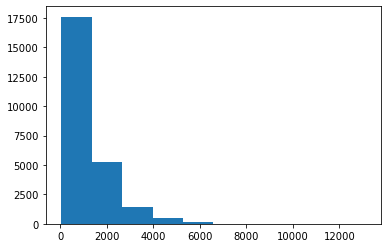

In [19]:
#
# Count length of text strings
#
textLength = []
for index in range (0,len(x_train)):
    textLength.append(len(x_train[index]))

#
# Plot histogram
#
plt.hist(textLength)
lengthArray = np.array(textLength)
print('text character length mean {}'.format(np.mean(lengthArray)))

# Convert words into tokens

In [20]:
#
# Split text up into tokens
#
tokenizer = Tokenizer(num_words=10000, lower=True, oov_token='unknwn')
#
# Train tokenizer
#
tokenizer.fit_on_texts(x_train)

In [21]:
#
# Convert words into integer sequences
#
x_train_v = tokenizer.texts_to_sequences(x_train)
x_test_v = tokenizer.texts_to_sequences(x_test)

In [22]:
# check original sentence
print(x_train[0], len(x_train[0]) )

Story of man who has unnatural feelings for pig Starts out with opening scene that is terrific example of absurd comedy formal orchestra audience is turned into an insane violent mob by the crazy chantings of it singers Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting Even those from the era should be turned off The cryptic dialogue would make Shakespeare seem easy to third grader On technical level it better than you might think with some good cinematography by future great Vilmos Zsigmond Future stars Sally Kirkland and Frederic Forrest can be seen briefly  629


In [23]:
# check token sequence
print(x_train_v[0], len(x_train_v[0]))

[60, 4, 122, 33, 44, 7445, 1383, 14, 4161, 501, 42, 15, 617, 131, 11, 6, 1271, 453, 4, 1705, 203, 1, 7348, 295, 6, 662, 80, 32, 2096, 1079, 2969, 31, 2, 893, 1, 4, 8, 5075, 460, 8, 2637, 1705, 2, 217, 54, 15, 55, 786, 1287, 826, 223, 8, 40, 95, 120, 1453, 56, 143, 35, 2, 956, 139, 26, 662, 120, 2, 1, 406, 58, 92, 1757, 301, 749, 5, 813, 1, 20, 1707, 630, 8, 125, 70, 19, 228, 99, 15, 46, 47, 613, 31, 677, 82, 1, 1, 677, 369, 3322, 1, 3, 1, 7918, 48, 26, 105, 3304] 105


In [24]:
# reverse tokens to text for check
text = tokenizer.sequences_to_texts([x_train_v[0]])
print(text)

['story of man who has unnatural feelings for pig starts out with opening scene that is terrific example of absurd comedy unknwn orchestra audience is turned into an insane violent mob by the crazy unknwn of it singers unfortunately it stays absurd the whole time with no general narrative eventually making it just too off putting even those from the era should be turned off the unknwn dialogue would make shakespeare seem easy to third unknwn on technical level it better than you might think with some good cinematography by future great unknwn unknwn future stars sally unknwn and unknwn forrest can be seen briefly']


vectorized length mean 226.28068


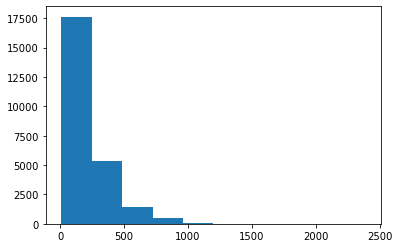

In [25]:
#
# Count length of integer sequences (aka word sequences)
#
textLength = []
for index in range (0,len(x_train_v)):
    textLength.append(len(x_train_v[index]))

#
# Plot histogram
#
plt.hist(textLength)
lengthArray = np.array(textLength)
print('vectorized length mean {}'.format(np.mean(lengthArray)))

In [26]:
#
# Get size of vocabulary of tokenizer
#
vocab_size = len(tokenizer.word_index) + 1
print('count of words {}'.format(vocab_size))

count of words 73530


# Task: select a proper maximum length of text (1 point)

Set maxlen to a suitable value for the text length. Longer text sequences are cut off, shorter sequences are padded.

In [27]:
# Ich nehme die durchschnittliche Textlänge als Maximum

In [28]:
def average(lst): 
    return sum(lst) / len(lst) 
maxlen = int(average(textLength))

In [29]:
#
# Pad sequences
#
x_train_v = pad_sequences(x_train_v, padding='post', maxlen=maxlen)
x_test_v = pad_sequences(x_test_v, padding='post', maxlen=maxlen)

# Download Glove models
[GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.](https://nlp.stanford.edu/projects/glove/)





In [30]:
gloveUrl = 'http://nlp.stanford.edu/glove.6B.zip'
gloveExtractionFolder = 'data/glove'
gloveDataArchive = gloveExtractionFolder + '/glove.6B.zip'

#
# Select 100 dims for embedding space
#
gloveData = gloveExtractionFolder + '/' + 'glove.6B.100d.txt'
gloveDims = 100

In [31]:
def unzip_dataset(dataset_file_path, extraction_directory):  
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)        
    zip = zipfile.ZipFile(dataset_file_path)
    zip.extractall(path=extraction_directory)        
    print("extraction of dataset from {} to {} done.".format(dataset_file_path,extraction_directory) )

In [32]:
#
# Execute download
#
if ( not os.path.exists(gloveData)):
    download_dataset(gloveUrl,gloveDataArchive,gloveExtractionFolder)

In [33]:
#
# Unzip glove
#
if ( not os.path.exists(gloveData)):
    unzip_dataset(gloveDataArchive,gloveExtractionFolder)

# Load glove embeddings into memory

In [34]:
#
# Create dict of glove vectors for each word in glove model
#
embeddings_dictionary = dict()
glove_file = open(gloveData, encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [35]:
print(len(embeddings_dictionary['the']))

100


In [36]:
for word, index in tokenizer.word_index.items():
    if(index%7501==0):
        print(word)

satanic
rumored
bleach
idolized
beet
weihenmayer
allusive
borrough
buttermilk


In [37]:
embedding_matrix = np.zeros((vocab_size, gloveDims))
print(embedding_matrix.shape)
# 73530 = Vocab dass ich aus den Comments erzeugt habe
# gloveDims = Aus dem pretrained Vector
print(embedding_matrix[2])
print(embedding_matrix[73529])

(73530, 100)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [38]:
#
# Copy glove vectors for each word in the tokenizer model
#
embedding_matrix = np.zeros((vocab_size, gloveDims))
for word, index in tokenizer.word_index.items():
    #print(word)
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [39]:
# check shape
print(embedding_matrix.shape)

(73530, 100)


# Task: Print some examples of glove vectors for words (1 point)

Select some random word from the tokenizer and print the glove vectors for those words.

In [40]:
print(len(list(tokenizer.word_index.keys())))
print(len(embedding_matrix))


73529
73530


In [41]:
#
# Result:
#

someNumber = 3

def returnSomeWordsFromTokenizer(number):
    returnList = []
    interimList = list(tokenizer.word_index.keys())
    randomlist = []
    for i in range(0,number):
        n = random.randint(1,len(interimList))
        randomlist.append(interimList[n])
    return(randomlist)
#listRandomWords = returnSomeWordsFromTokenizer(someNumber)

def printVector(someNumber):
    wordingList = returnSomeWordsFromTokenizer(someNumber)
    for word in wordingList:
        print(word)
        print(embeddings_dictionary[word])
        
printVector(someNumber)

counterculture
[ 0.15349    0.50122   -0.1809    -0.48029    0.02361    0.71774
 -0.21085   -0.75048   -0.0019896  0.82295   -0.21566   -0.38023
 -0.66459   -0.45833    0.21449    0.11166    0.22101   -0.13607
  0.42996   -0.16288    0.36205    0.23642    0.052333  -0.30428
 -0.034045   0.35305    0.22006   -0.97723   -0.062583  -0.16177
  0.18757    0.19923   -0.21413    0.7281    -0.22562   -0.36698
  0.17307   -0.027887   0.32421   -0.93756   -0.41259    0.2157
  0.18947    0.35217    0.12168   -0.3786     1.1456     0.51183
  0.15035    0.26981   -0.11518    0.27657    0.09155   -0.0091759
 -0.17851    0.31174   -0.68437    0.64491    0.46658    0.39113
  0.12987    0.80004    0.10756   -0.57317    0.51623   -0.63218
  0.5533    -0.98339    0.65706    0.033639   0.74332   -0.23175
 -0.91126    0.048412  -0.91224   -0.52944    0.59903   -0.5017
  0.15238   -0.61384   -0.96819    0.37858    0.91837    0.20121
 -0.092778   0.47721   -0.29522   -0.072558  -0.74166   -0.060152
  0.40256

# Create a simple model

**Note** how the embedding_matrix is used in the first layer to embed the token integers into vectors.

In [42]:
def createNNModel():
    model = Sequential()
    embedding_layer = Embedding(vocab_size, gloveDims, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    model.add(Flatten())
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [43]:
model = createNNModel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 226, 100)          7353000   
_________________________________________________________________
flatten (Flatten)            (None, 22600)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2260100   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 9,613,201
Trainable params: 2,260,201
Non-trainable params: 7,353,000
_________________________________________________________________
None


In [44]:
history = model.fit(x_train_v, y_train, batch_size=128, epochs=BasicNNEpochen, verbose=1, validation_split=0.2)

Epoch 1/50
157/157 [==============================] - 10s 66ms/step - loss: 0.8873 - acc: 0.6153 - val_loss: 0.9173 - val_acc: 0.2952
Epoch 2/50
157/157 [==============================] - 9s 55ms/step - loss: 0.5446 - acc: 0.7440 - val_loss: 0.8202 - val_acc: 0.5082
Epoch 3/50
157/157 [==============================] - 9s 59ms/step - loss: 0.4295 - acc: 0.8240 - val_loss: 0.8694 - val_acc: 0.5340
Epoch 4/50
157/157 [==============================] - 9s 57ms/step - loss: 0.3425 - acc: 0.8682 - val_loss: 0.6982 - val_acc: 0.6520
Epoch 5/50
157/157 [==============================] - 9s 59ms/step - loss: 0.2607 - acc: 0.9113 - val_loss: 1.0312 - val_acc: 0.5294
Epoch 6/50
157/157 [==============================] - 9s 57ms/step - loss: 0.2025 - acc: 0.9392 - val_loss: 1.2538 - val_acc: 0.4522
Epoch 7/50
157/157 [==============================] - 9s 59ms/step - loss: 0.1667 - acc: 0.9518 - val_loss: 0.9975 - val_acc: 0.5994
Epoch 8/50
157/157 [==============================] - 9s 58ms/step -

In [45]:
score = model.evaluate(x_test_v, y_test, verbose=1)

782/782 [==============================] - 7s 8ms/step - loss: 1.3561 - acc: 0.7007


In [46]:
print("test loss:", score[0])
print("test accuracy:", score[1])

test loss: 1.3561043739318848
test accuracy: 0.7006800174713135


In [47]:
def plotResults(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

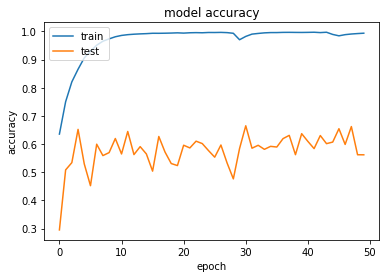

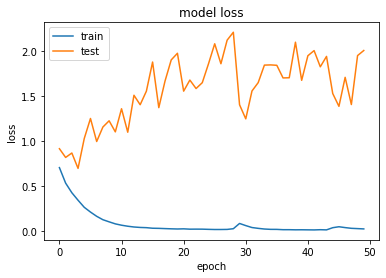

In [48]:
plotResults(history)

# Save model

In [50]:
#
# Save a model for later use
#
from keras.models import model_from_json

prefix = 'results/02_'
modelName = prefix + "model.json"
weightName = prefix + "model.h5"


def handle_model(model,save_model):
    # set to True if the model should be saved
    if save_model:
        model_json = model.to_json()
        with open( modelName , "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights( weightName )
        print("saved model to disk as {} {}".format(modelName,weightName))
        return model
    

    # load model (has to be saved before, is not part of git)    
    if not save_model:
        json_file = open(modelName, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        # load weights into new model
        loaded_model.load_weights(weightName)
        print("loaded model from disk")        
        return loaded_model

In [49]:
model = handle_model(model,True)

saved model to disk as results/02_model.json results/02_model.h5


# Task: Improved model based on LSTMs (2 points)

The previous model reaches around 70% of test accuracy. This is not sufficient for your customer. So we need a better model. Research the internet for sentiment analysis models using LSTMs and implement a better version of the model based on this information.

1. Implement an LSTM based model version for sentiment analysis (you can also use a different model if you find publications for it)
1. Document the sources you have found
1. Test the model in comparison to the older model version

In [50]:
#
# Result: new model
#
def createLSTMModel():
    model = Sequential()
    embedding_layer = Embedding(vocab_size, gloveDims, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

In [51]:
model2 = createLSTMModel()

In [52]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 226, 100)          7353000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 7,470,377
Trainable params: 117,377
Non-trainable params: 7,353,000
_________________________________________________________________
None


In [53]:
history = model2.fit(x_train_v, y_train, batch_size=128, epochs=ImprovedModel, verbose=1, validation_split=0.2)
score = model2.evaluate(x_test_v, y_test, verbose=1)

Epoch 1/10
157/157 [==============================] - 294s 2s/step - loss: 0.6603 - acc: 0.6269 - val_loss: 0.9709 - val_acc: 0.1012
Epoch 2/10
157/157 [==============================] - 308s 2s/step - loss: 0.6565 - acc: 0.6541 - val_loss: 1.0503 - val_acc: 2.0000e-04
Epoch 3/10
157/157 [==============================] - 320s 2s/step - loss: 0.6586 - acc: 0.6255 - val_loss: 0.9644 - val_acc: 0.0670
Epoch 4/10
157/157 [==============================] - 324s 2s/step - loss: 0.6488 - acc: 0.6384 - val_loss: 1.1421 - val_acc: 0.0692
Epoch 5/10
157/157 [==============================] - 328s 2s/step - loss: 0.5698 - acc: 0.7049 - val_loss: 0.6065 - val_acc: 0.7262
Epoch 6/10
157/157 [==============================] - 327s 2s/step - loss: 0.4047 - acc: 0.8214 - val_loss: 0.7339 - val_acc: 0.6022
Epoch 7/10
157/157 [==============================] - 328s 2s/step - loss: 0.3971 - acc: 0.8290 - val_loss: 0.5302 - val_acc: 0.7532
Epoch 8/10
157/157 [==============================] - 330s 2s/ste

In [54]:
print("test loss:", score[0])
print("test accuracy:", score[1])

test loss: 0.4358437955379486
test accuracy: 0.8030400276184082


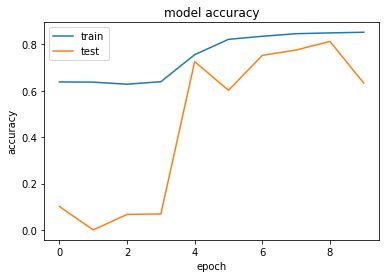

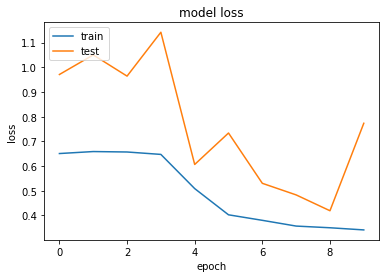

In [55]:
plotResults(history)

In [56]:
model2 = handle_model(model2,True)

saved model to disk as results/02_model.json results/02_model.h5


# Task: Replace 100 d model with 300 d model for embedding (2 points)

Try better embedding model with 300 dimensions instead of the 100 dimension model. Load the different Glove weights, update the vector matrix for the embedding layer and the model structure for the better Glove model.


In [42]:
gloveData = gloveExtractionFolder + '/' + 'glove.6B.300d.txt'
gloveDims = 300
# Load glove embeddings into memory¶
embeddings_dictionary = dict()
glove_file = open(gloveData, encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [43]:
print(len(embeddings_dictionary['the']))

300


In [44]:
embedding_matrix = np.zeros((vocab_size, gloveDims))
print(embedding_matrix.shape)

(73530, 300)


In [45]:
embedding_matrix = np.zeros((vocab_size, gloveDims))
for word, index in tokenizer.word_index.items():
    #print(word)
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
print(embedding_matrix.shape)

(73530, 300)


In [46]:
# CheckVecot
someNumber = 3
printVector(someNumber)

afloat
[ 0.34422   -0.26506   -0.079252   0.031283   0.59874   -0.065493
  0.20436   -0.49943   -0.13972   -0.55956    0.4486     0.018748
  0.15387   -0.15662   -0.10055    0.050015  -0.041241  -0.16123
  0.0036883 -0.5018     0.45497   -0.11354    0.49982    0.20653
  0.45676   -0.25825   -0.6354     0.65071   -0.4791     0.98903
 -0.16508   -0.089842   0.24866   -0.10836   -0.061778  -0.11268
 -0.0082934  0.13527    0.33242    0.16828   -0.0065926 -0.38829
  0.15563    0.46685   -0.13671    0.20964    0.67408   -0.020772
 -0.29837    0.086152   0.44294    0.06595    0.62687   -1.032
 -0.11953   -0.47521    0.24561    0.59252   -0.40056    0.18437
  0.16494   -0.46523    0.03746    0.25837    0.44265    0.16254
 -0.24062   -0.25099   -0.17595    0.079686  -0.29148    0.58751
 -0.27016   -0.027613   0.35962   -0.39758    0.15746   -0.097824
  0.34502   -0.014896  -0.20374   -0.076557  -0.63644    0.38698
  0.17411    0.5922    -0.5527    -0.36183   -1.031     -0.023998
  0.45831    0.

KeyError: 'kabei'

In [61]:
# direkt ins LSTM, das BASIS-NN überspringe ich
model3 = createLSTMModel()
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 226, 300)          22059000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 22,278,777
Trainable params: 219,777
Non-trainable params: 22,059,000
_________________________________________________________________
None


In [62]:
history_300d = model3.fit(x_train_v, y_train, batch_size=128, epochs=improved300epochen, verbose=1, validation_split=0.2)
score_300d = model3.evaluate(x_test_v, y_test, verbose=1)

Epoch 1/10
157/157 [==============================] - 608s 4s/step - loss: 0.6571 - acc: 0.6337 - val_loss: 0.6630 - val_acc: 0.3586
Epoch 2/10
157/157 [==============================] - 679s 4s/step - loss: 0.6432 - acc: 0.6314 - val_loss: 1.2434 - val_acc: 0.1086
Epoch 3/10
157/157 [==============================] - 730s 5s/step - loss: 0.6510 - acc: 0.6254 - val_loss: 1.0861 - val_acc: 0.1712
Epoch 4/10
157/157 [==============================] - 753s 5s/step - loss: 0.6332 - acc: 0.6541 - val_loss: 0.7837 - val_acc: 0.3488
Epoch 5/10
157/157 [==============================] - 759s 5s/step - loss: 0.6197 - acc: 0.6598 - val_loss: 0.8889 - val_acc: 0.5928
Epoch 6/10
157/157 [==============================] - 761s 5s/step - loss: 0.6456 - acc: 0.6555 - val_loss: 1.0388 - val_acc: 0.0102
Epoch 7/10
157/157 [==============================] - 765s 5s/step - loss: 0.6401 - acc: 0.6425 - val_loss: 0.9732 - val_acc: 0.0742
Epoch 8/10
157/157 [==============================] - 761s 5s/step - 

In [63]:
print("test loss:", score_300d[0])
print("test accuracy:", score_300d[1])

test loss: 0.40231165289878845
test accuracy: 0.8312000036239624


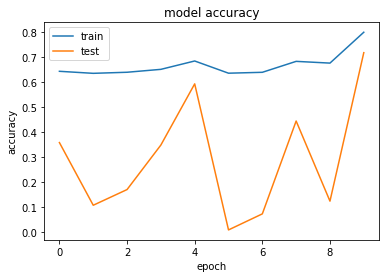

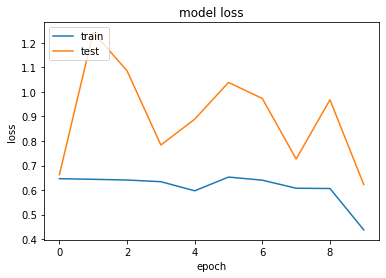

In [64]:
plotResults(history_300d)

# Task: Replace Glove model with BERT model vectors (2 points)

Try to replace Glove with a BERT model. This is no easy task. Research the internet for tutorials about this goal and write down all changes you would need to implement for this change (concept only, implementation optional).


[LINK Basic TUtorial](https://towardsdatascience.com/bert-text-classification-in-3-lines-of-code-using-keras-264db7e7a358)



In [65]:
import matplotlib

In [66]:
#!pip install ktrain
import ktrain
from ktrain import text

In [67]:
trn, val, preproc = text.texts_from_folder(textData, 
                                          maxlen=500, 
                                          preprocess_mode='bert',
                                          train_test_names=['train', 
                                                            'test'],
                                          classes=['pos', 'neg'])

detected encoding: utf-8
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [68]:
model = text.text_classifier('bert', trn, preproc=preproc)
learner = ktrain.get_learner(model,train_data=trn, val_data=val, batch_size=6)

Is Multi-Label? False
maxlen is 500
done.


In [ ]:
# Train & Fine-Tune Model
historyLearner = learner.fit_onecycle(2e-3, 1)



begin training using onecycle policy with max lr of 0.002...
  49/4167 [..............................] - ETA: 119:58:13 - loss: 0.8397 - accuracy: 0.5215

Ich habe den oberen Junk ausgeblendet, da dieser auf meiner Hardware unverhältnimäßig lange rechnet. Siehe folgendes Bild:

------------
------------
------------
![Folder-Strucutre](./imgs/ProblemZeit.png)

------------
------------
------------

Ich habe es so gelöst, dass ich den Teil des BERT-Models auf dem leistungsstarken Kubernete Cluster der FH laufen gelassen habe. Das fertige Modell habe ich von dem Cluster auf einen privaten FTP-Server geladen und das Model anschließend auf meine Hardware  geladen. Konkret habe ich folgendes gitalb.ci.yml - File erstellt:

```
stages:
    - MillingerRun
ExecuteBERT:
    stage: MillingerRun
    image: jhc1990/mlunnerk8sfh
    script:
        - mkdir results
        - python code-to-run.py
```

Für den Run habe ich diesen [Docker-Container](https://hub.docker.com/r/jhc1990/ml_exercise_ditmil_imdb) in Eigenarbeit gebaut.

Der tatsächliche Code im File "code-to-run.py" File ist der Code des gegenwärtig betrachteten Notebooks, angereichert um die Implementierung des FTP-Servers, auf welchen das fertig trainierte Modell deployt wurde.

```
import ftplib
session = ftplib.FTP('188.174.171.206','ftpuser','0c5acc0ae8793d0ed4f262c8d8c12adafd3b5104e0e3519b971b35f14596772f')
session.cwd('MillingerML')

file = open('results/03_BERT_model.h5','rb')                  # file to send
session.storbinary('STOR 03_BERT_model.h5', file)     # send the file
file.close()                                    # close file and FTP

file = open('results/03_BERT_model.json','rb')                  # file to send
session.storbinary('STOR 03_BERT_model.json', file)     # send the file
file.close()                                    # close file and FTP

session.quit()
```

Ich lasse den FTP-Server noch online für den Fall, dass dieses fertige Modell eingesehen bzw heruntergeladen werden soll. mit ein bisschen IT-Know-How findet man sicher die nötigen Credentials im oberen Junk heraus :-). 

Hier ein Screenshot von dem abgeschlossenen Run:
![Folder-Strucutre](./imgs/gitlab.png)

Auch hier ist eine "halbe" Ewigkeit verstrichen bis das Model fertig trainiert war(~1200 Minuten = ca 20h // im Vergleich zu 120 Tagen Training auf meiner Hardware aber eigentlich ganz annhembar. 

# Test with your own data

In [47]:
instance = x_test_clean[56]
print(instance)

From time to time it very advisable for the aristocracy to watch some silent film about the harsh life of the common people in order to remind themselves of the privileges and the comfortable life that they have enjoyed since the beginning of mankind or even before in comparison with the complicated and hard work that common people have to endure everyday since the aristocrats rule the world br br And that what happens in The Love Light the first film directed by Dame France Marion who will be famous afterwards in the silent and talkie world thanks overall to her work as screenwriter better for her certainly because her career as film director doesn impress this German count br br The film tells the story of Dame Angela Carlotti Dame Mary Pickford merry Italian girl who lives surrounded by picturesque squalor an important difference of opinion between upper and low classes aristocrats prefers to live surrounded by picturesque luxury she has two brothers and secret admirer but all she g

In [48]:
def sentiment(text):
    
    instance = tokenizer.texts_to_sequences(text)
    flat_list = []
    for sublist in instance:
        for item in sublist:
            flat_list.append(item)

    flat_list = [flat_list]
    instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)
    sentiment = model2.predict(instance)
    
    comment = 'meh'
    if sentiment > 0.85:
        comment = 'very good'
    elif sentiment > 0.75:
        comment = 'good'
    elif sentiment > 0.50:
        comment = 'moderate'
    return sentiment,comment

In [52]:
model2 = handle_model("./results/02_model",False)

loaded model from disk


In [53]:
test1 = "I simply don't like this film."
print ( sentiment(test1))

(array([[0.9579619]], dtype=float32), 'very good')


In [54]:
test1 = "I hate this film."
print ( sentiment(test1))

(array([[0.93643403]], dtype=float32), 'very good')


In [55]:
test1 = "I love this film."
print ( sentiment(test1))

(array([[0.93643403]], dtype=float32), 'very good')


In [56]:
test1 = x_test_clean[13000]
print ( sentiment(test1))

(array([[0.81808805]], dtype=float32), 'good')


In [57]:
tend = datetime.now()
print(tend)
print("Der Lauf des gesamten Notebooks dauert: " + str(tend-tstart))

2020-08-22 22:13:49.596099
Der Lauf des gesamten Notebooks dauert: 0:13:33.705048
